In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import welch

# Utility Functions

from PIL import Image  # For GIF handling

def load_video(video_path):
    """
    Loads a video (MP4 or GIF) from the specified path and returns a list of frames.
    Each frame is converted to grayscale (luminance).
    """
    frames = []
    file_extension = os.path.splitext(video_path)[-1].lower()

    if file_extension in [".mp4", ".avi", ".mov"]:
        # Use OpenCV for video files
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise FileNotFoundError(f"Unable to load video at {video_path}")

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Convert to grayscale (luminance)
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray_frame)
        cap.release()

    elif file_extension in [".gif"]:
        # Use Pillow for GIFs
        gif = Image.open(video_path)
        try:
            while True:
                # Convert to grayscale and append
                frame = gif.convert("L")  # "L" mode is grayscale
                frames.append(np.array(frame))
                gif.seek(gif.tell() + 1)
        except EOFError:
            pass  # End of GIF

    else:
        raise ValueError(f"Unsupported file format: {file_extension}")

    if not frames:
        raise ValueError("No frames could be loaded from the video.")
    
    return np.array(frames)  # Shape: (num_frames, height, width)


def downsample_video(frames, num_sections):
    """
    Averages luminance values into equally sized subsections.
    """
    height, width = frames.shape[1], frames.shape[2]
    section_height = height // num_sections
    section_width = width // num_sections

    downsampled = []
    for i in range(num_sections):
        for j in range(num_sections):
            section = frames[:,
                             i * section_height:(i + 1) * section_height,
                             j * section_width:(j + 1) * section_width]
            downsampled.append(section.mean(axis=(1, 2)))  # Average over spatial dimensions
    return np.array(downsampled)  # Shape: (num_sections^2, num_frames)

def compute_psd_welch(time_series, fs, nperseg):
    """
    Computes Power Spectral Density (PSD) using Welch's method for each time series.
    
    Parameters:
    - time_series: Array of shape (num_subsections, num_frames)
    - fs: Sampling frequency (Hz)
    - nperseg: Length of each segment for Welch's method (controls frequency resolution)
    
    Returns:
    - freqs: Array of frequency bins
    - psd: PSD values for each subsection
    """
    psd_list = []
    freqs = None
    for ts in time_series:
        f, p = welch(ts, fs=fs, nperseg=nperseg)
        if freqs is None:
            freqs = f
        psd_list.append(p)
    return freqs, np.array(psd_list)

def visualize_psd(freqs, psd, num_sections, max_x=3, image_title=""):
    """
    Visualizes all the PSDs for averaged subsections.
    """
    num_subsections = num_sections ** 2
    colors = plt.cm.viridis(np.linspace(0, 1, num_subsections))

    plt.figure(figsize=(10, 6))
    for i in range(num_subsections):
        plt.plot(freqs, psd[i], color=colors[i], alpha=0.7, label=f"Subsection {i + 1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.xlim(0, max_x)
    plt.title(f"Power Spectral Density of {num_subsections} Subsections for {image_title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_top_frequencies(freqs, avg_psd, top_n=10):
    """
    Finds the top `n` frequencies and corresponding amplitudes from the averaged PSD.
    """
    sorted_indices = np.argsort(avg_psd)[::-1]  # Sort in descending order
    top_indices = sorted_indices[:top_n]
    top_freqs = freqs[top_indices]
    top_amps = avg_psd[top_indices]
    return top_freqs, top_amps

# Main Script

def process_video(video_path, num_sections=32, fs=30, nperseg=128, max_x=3, top_n=10):
    """
    Processes the video and visualizes PSDs of averaged luminance subsections.
    
    Parameters:
    - video_path: Path to the video file
    - num_sections: Number of subsections along one dimension (total subsections = num_sections^2)
    - fs: Sampling frequency of the video (Hz)
    - nperseg: Length of each segment for Welch's method (higher value = better frequency resolution)
    - max_x: Maximum frequency displayed in the plot.
    - top_n: Number of top frequencies to return.
    
    Returns:
    - top_freqs: Top `n` frequencies.
    - top_amps: Corresponding amplitudes of the top frequencies.
    """
    # Load video frames
    frames = load_video(video_path)
    print(f"Video loaded: {frames.shape[0]} frames, {frames.shape[1]}x{frames.shape[2]} resolution.")

    # Downsample to subsections
    downsampled_luminance = downsample_video(frames, num_sections)
    print(f"Luminance downsampled into {num_sections ** 2} subsections with shape: {downsampled_luminance.shape}")

    # Compute PSD using Welch's method
    freqs, psd = compute_psd_welch(downsampled_luminance, fs=fs, nperseg=nperseg)
    print(f"PSD computed for {num_sections ** 2} subsections with frequency bins: {len(freqs)}")

    # Compute average PSD across all subsections
    avg_psd = psd.mean(axis=0)

    # Find top frequencies and amplitudes
    top_freqs, top_amps = get_top_frequencies(freqs, avg_psd, top_n=top_n)
    print(f"Top {top_n} frequencies: {top_freqs}")
    print(f"Top {top_n} amplitudes: {top_amps}")

    # Visualize PSD
    visualize_psd(freqs, psd, num_sections, max_x=max_x, image_title=os.path.basename(video_path))
    print("PSD visualization completed.")
    
    return top_freqs, top_amps


Video loaded: 514 frames, 360x480 resolution.
Luminance downsampled into 900 subsections with shape: (900, 514)


c:\Users\skite\miniconda3\envs\goofi\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 514, using nperseg = 514
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


PSD computed for 900 subsections with frequency bins: 258
Top 20 frequencies: [0.05836576 0.11673152 0.23346304 0.         0.29182879 0.35019455
 0.17509728 0.40856031 0.46692607 0.52529183 0.58365759 0.64202335
 0.81712062 0.87548638 0.9922179  0.75875486 1.16731518 0.93385214
 0.70038911 1.05058366]
Top 20 amplitudes: [341.98096665 102.08558001  80.74756064  68.51502662  63.15759176
  62.37094605  61.738257    51.31784983  47.02358765  43.7366891
  33.57056178  30.46160432  29.67377076  27.42373211  27.33046276
  26.12480494  25.4494392   25.3395313   22.5944848   21.78097379]


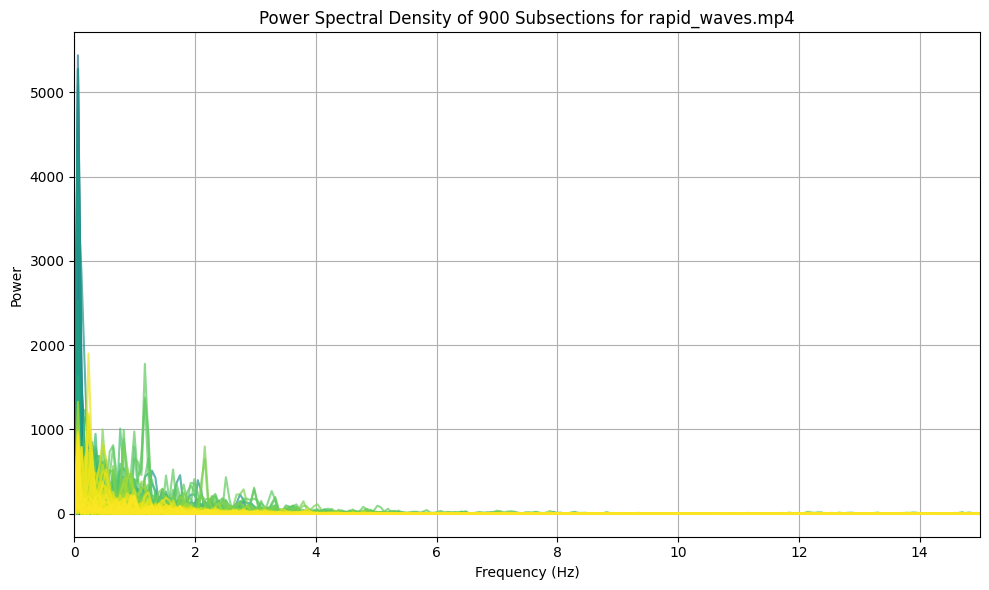

PSD visualization completed.


In [73]:
import os
#load all files in the directory and process them
video_path = "../image_database/rapid_waves.mp4"
top_freqs, top_amps = process_video(video_path, num_sections=30, fs=30, nperseg=1024, max_x=15, top_n=20)

Processing video: ../image_database\forest.mp4
Video loaded: 487 frames, 720x1280 resolution.
Luminance downsampled into 900 subsections with shape: (900, 487)
PSD computed for 900 subsections with frequency bins: 244
Top 10 frequencies: [0.06160164 0.12320329 0.18480493 0.24640657 0.30800821 0.
 0.36960986 0.4312115  0.49281314 0.55441478]
Top 10 amplitudes: [1202.69394826  784.35941996  377.25861055  254.68222745  173.80137885
  126.81002033  115.65650612   88.43625977   70.49449044   55.05743035]


c:\Users\skite\miniconda3\envs\goofi\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 487, using nperseg = 487
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


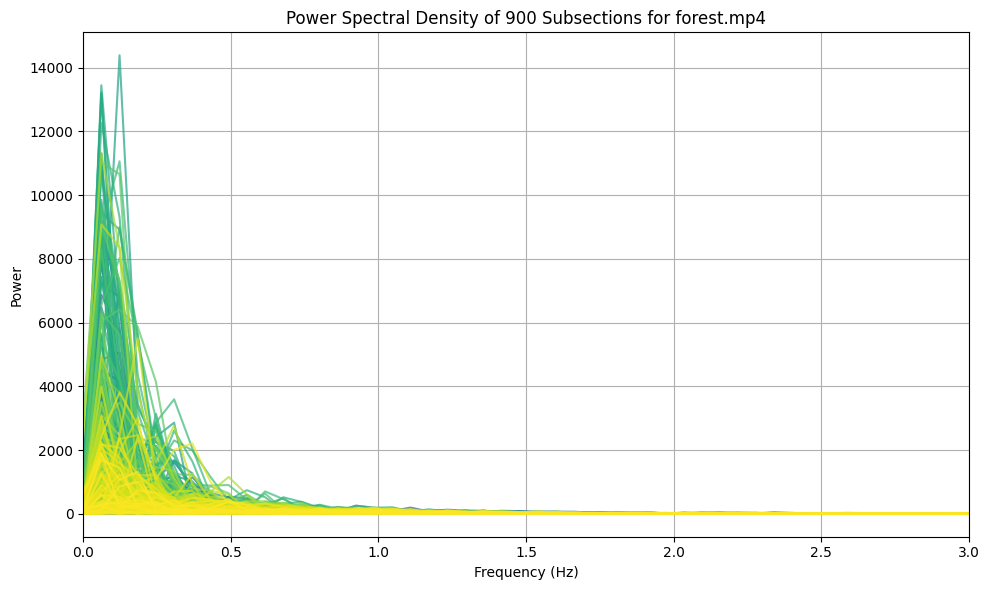

PSD visualization completed.
Processing video: ../image_database\generated_python3.mp4
Video loaded: 100 frames, 600x800 resolution.
Luminance downsampled into 900 subsections with shape: (900, 100)


c:\Users\skite\miniconda3\envs\goofi\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 100, using nperseg = 100
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


PSD computed for 900 subsections with frequency bins: 51
Top 10 frequencies: [0.3 0.6 0.9 0.  1.2 1.5 1.8 2.1 2.4 2.7]
Top 10 amplitudes: [2.96748610e+01 6.32520842e+00 3.39666387e+00 2.83378884e+00
 2.27655661e+00 1.13550152e-01 7.16932642e-03 4.01271415e-03
 2.17586298e-03 1.81687758e-03]


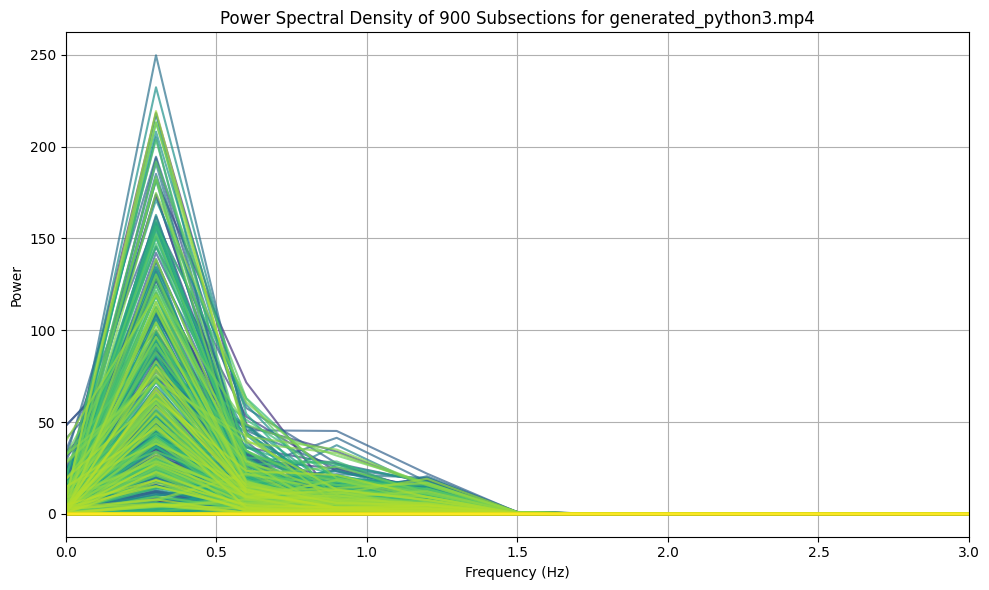

PSD visualization completed.
Processing video: ../image_database\generated_python_waves.mp4
Video loaded: 100 frames, 600x800 resolution.
Luminance downsampled into 900 subsections with shape: (900, 100)
PSD computed for 900 subsections with frequency bins: 51
Top 10 frequencies: [ 0.6 12.   0.3 12.3  1.5  1.8  1.2  0.9  0.  11.7]
Top 10 amplitudes: [330.63825343 258.65383983 249.70338269 200.26942917 137.91347092
  40.25540694  30.30440553  29.48890646  22.58682365  19.28351377]


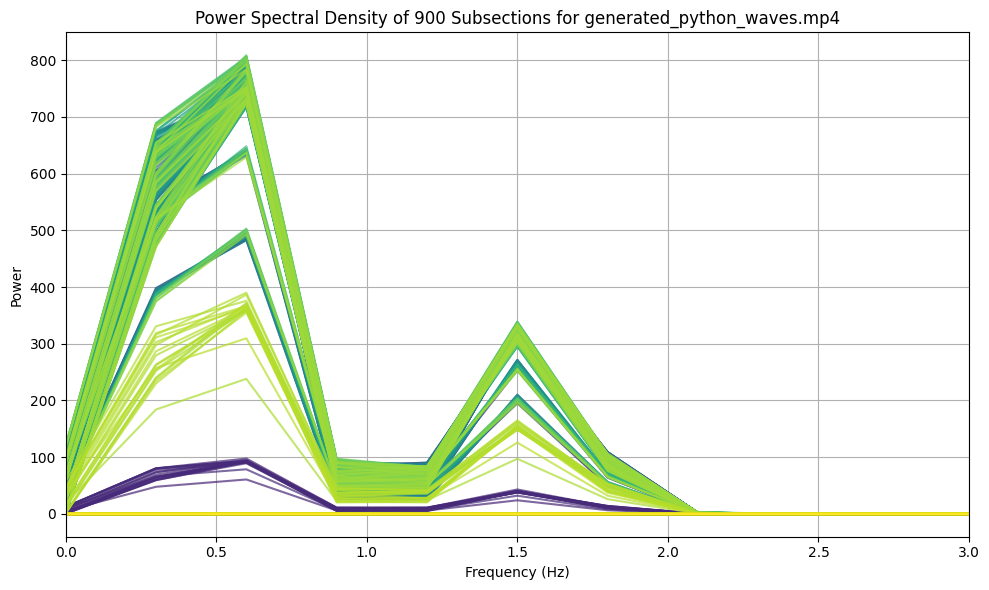

PSD visualization completed.
Processing video: ../image_database\generated_waves.mp4
Video loaded: 300 frames, 720x1280 resolution.
Luminance downsampled into 900 subsections with shape: (900, 300)
PSD computed for 900 subsections with frequency bins: 151
Top 10 frequencies: [0.3 0.4 0.5 0.2 0.6 0.7 0.8 0.1 0.9 1. ]
Top 10 amplitudes: [1038.10378394  918.60801547  624.76474143  303.85946915  296.90536377
  171.24894663  112.11014307  103.79068438   55.69096489   31.85032133]


c:\Users\skite\miniconda3\envs\goofi\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 300, using nperseg = 300
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


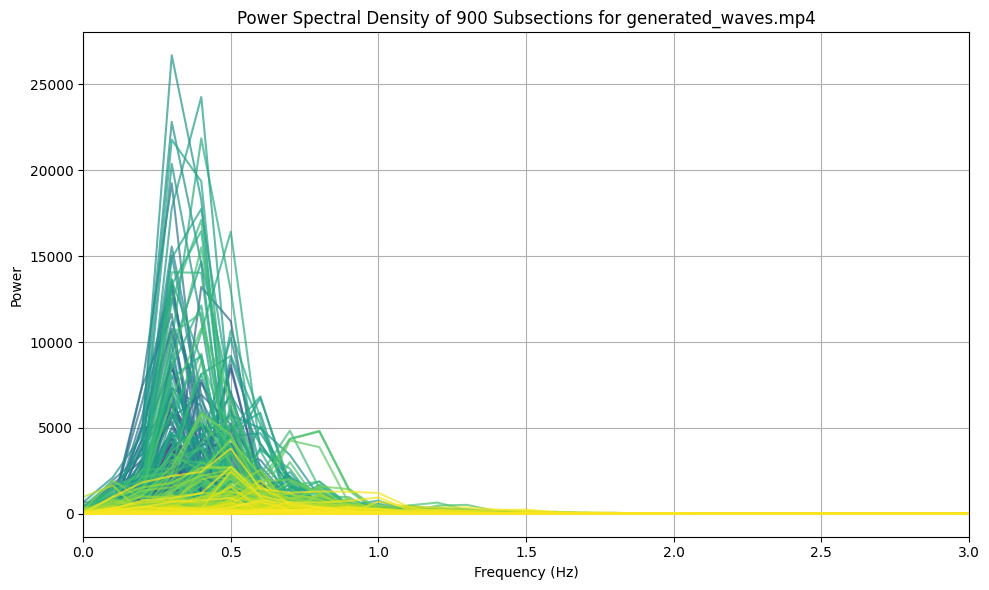

PSD visualization completed.
Processing video: ../image_database\rapid_waves.mp4
Video loaded: 514 frames, 360x480 resolution.
Luminance downsampled into 900 subsections with shape: (900, 514)
PSD computed for 900 subsections with frequency bins: 258
Top 10 frequencies: [0.05836576 0.11673152 0.23346304 0.         0.29182879 0.35019455
 0.17509728 0.40856031 0.46692607 0.52529183]
Top 10 amplitudes: [341.98096665 102.08558001  80.74756064  68.51502662  63.15759176
  62.37094605  61.738257    51.31784983  47.02358765  43.7366891 ]


c:\Users\skite\miniconda3\envs\goofi\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 514, using nperseg = 514
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


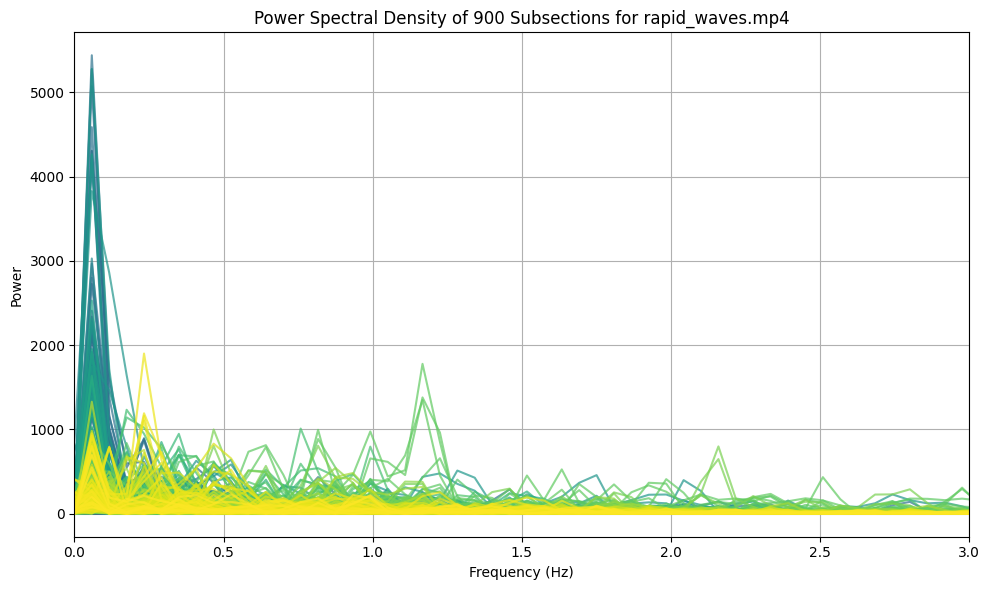

PSD visualization completed.
Processing video: ../image_database\tessendorf.mp4
Video loaded: 200 frames, 480x640 resolution.
Luminance downsampled into 900 subsections with shape: (900, 200)


c:\Users\skite\miniconda3\envs\goofi\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 200, using nperseg = 200
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


PSD computed for 900 subsections with frequency bins: 101
Top 10 frequencies: [0.45 0.3  0.6  0.75 0.9  0.15 1.05 0.   1.2  1.35]
Top 10 amplitudes: [2866.12285814 2153.7686113   724.12178589  285.64220442  108.99135599
   76.1026042    36.34934837   17.18844155   17.12139308    9.00744574]


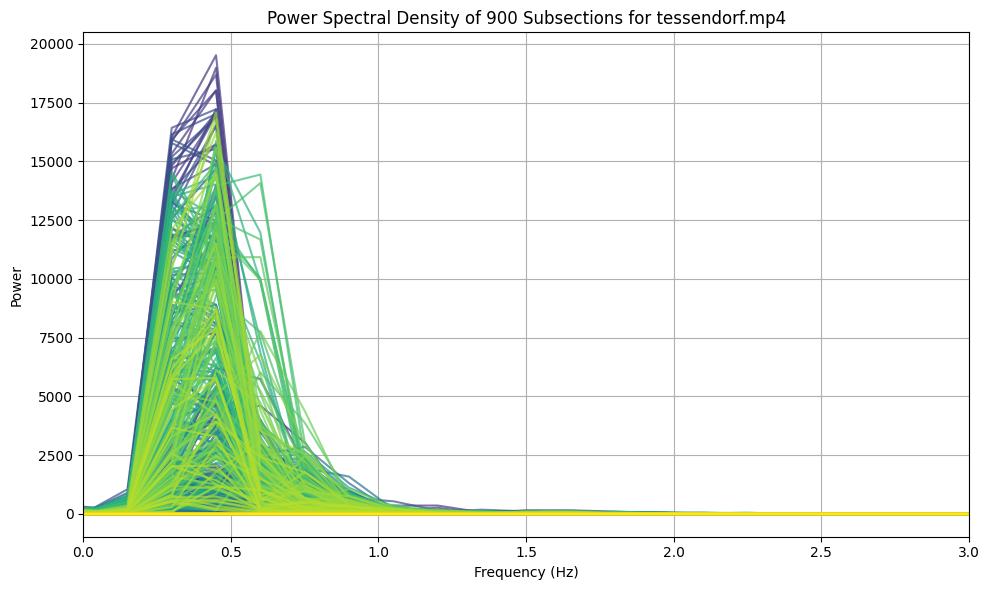

PSD visualization completed.
Processing video: ../image_database\waves.mp4
Video loaded: 450 frames, 720x1280 resolution.
Luminance downsampled into 900 subsections with shape: (900, 450)
PSD computed for 900 subsections with frequency bins: 226
Top 10 frequencies: [0.06666667 0.13333333 0.2        0.26666667 0.         0.33333333
 0.4        0.46666667 0.53333333 0.6       ]
Top 10 amplitudes: [2481.71131048 1860.19327566 1371.83158584  971.49581472  657.85603847
  612.69587551  410.58024885  283.85828441  230.01106568  166.55632568]


c:\Users\skite\miniconda3\envs\goofi\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 450, using nperseg = 450
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


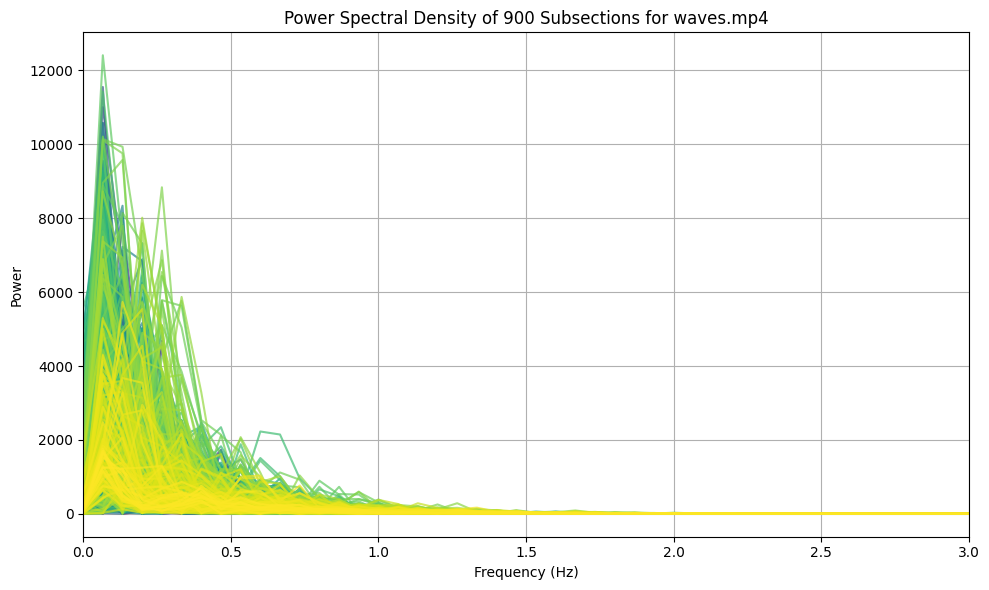

PSD visualization completed.


In [88]:
import os
#load all files in the directory and process them
dir = "../image_database"

for file in os.listdir(dir):
    # check if file is video
    if not file.endswith(".mp4" or ".gif"):
        continue
    video_path = os.path.join(dir, file)
    print(f"Processing video: {video_path}")
    process_video(video_path, num_sections=30, fs=30, nperseg=1024, max_x=3)

## Generate wave patterns

MovieWriter imagemagick unavailable; using Pillow instead.


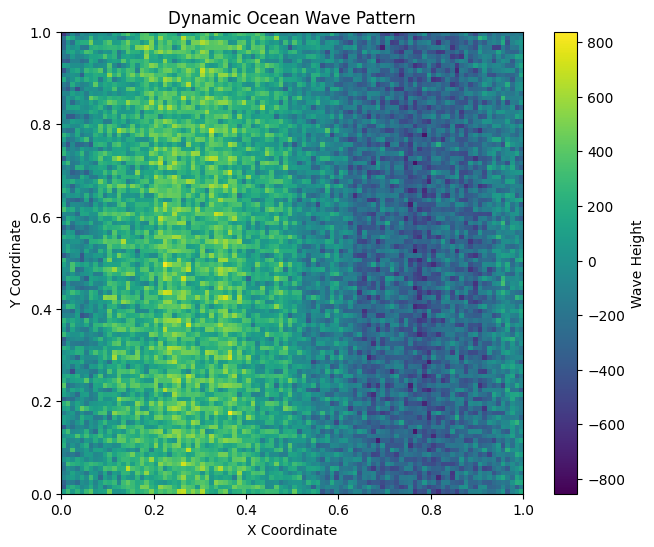

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def generate_ocean_waves(grid_size, num_frames, freqs, amplitudes, directions, resolution=100):
    """
    Generates ocean wave patterns with specific temporal frequencies.
    
    Parameters:
    - grid_size: Tuple of (width, height) of the spatial grid.
    - num_frames: Number of time frames.
    - freqs: List of desired temporal frequencies (Hz).
    - amplitudes: List of amplitudes for each frequency.
    - directions: List of directions (angles in radians) for each frequency.
    - resolution: Spatial resolution (number of grid points).
    
    Returns:
    - waves: A 3D numpy array of shape (num_frames, resolution, resolution) with wave patterns.
    """
    width, height = grid_size
    x = np.linspace(0, width, resolution)
    y = np.linspace(0, height, resolution)
    X, Y = np.meshgrid(x, y)

    time = np.linspace(0, num_frames / 30, num_frames)  # Assuming 30 FPS
    waves = np.zeros((num_frames, resolution, resolution))

    for f, A, direction in zip(freqs, amplitudes, directions):
        kx = np.cos(direction)  # X component of wave direction
        ky = np.sin(direction)  # Y component of wave direction
        for t_idx, t in enumerate(time):
            wave = A * np.sin(2 * np.pi * f * t + 2 * np.pi * (kx * X + ky * Y))
            waves[t_idx] += wave

    return waves

def animate_waves(waves, interval=100):
    """
    Dynamically visualizes the wave pattern frames as an animation.
    
    Parameters:
    - waves: A 3D numpy array of shape (num_frames, resolution, resolution).
    - interval: Time between frames in milliseconds.
    """
    num_frames, resolution, _ = waves.shape

    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(waves[0], cmap="viridis", extent=[0, 1, 0, 1], animated=True)
    ax.set_title("Dynamic Ocean Wave Pattern")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    plt.colorbar(img, ax=ax, label="Wave Height")

    def update(frame):
        img.set_array(waves[frame])
        return img,

    ani = FuncAnimation(fig, update, frames=num_frames, interval=interval, blit=True)
    ani.save("ocean_waves.gif", writer="imagemagick")
    plt.show()

# Example Parameters
grid_size = (100, 100)  # Spatial size (arbitrary units)
num_frames = 500      # Number of frames
freqs = list(top_freqs)  # Temporal frequencies in Hz
amplitudes = list(top_amps)  # Amplitudes of waves
directions = list(np.linspace(0, 2 * np.pi, len(freqs)))  # Random directions

# Generate Ocean Waves
waves = generate_ocean_waves(grid_size, num_frames, freqs, amplitudes, directions)

# Animate the Waves
animate_waves(waves, interval=100)  # 100 ms per frame


In [70]:
top_freqs, top_amps

(array([0.05836576, 0.11673152, 0.23346304, 0.        , 0.29182879,
        0.35019455, 0.17509728, 0.40856031, 0.46692607, 0.52529183]),
 array([341.98096665, 102.08558001,  80.74756064,  68.51502662,
         63.15759176,  62.37094605,  61.738257  ,  51.31784983,
         47.02358765,  43.7366891 ]))